In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load the edge list
edges = pd.read_csv('musae_git_edges.csv')

# Load the target (labels)
targets = pd.read_csv('musae_git_target.csv')

# Load the features (JSON format)
with open('musae_git_features.json', 'r') as f:
    features = json.load(f)

# Create a NetworkX graph
G = nx.from_pandas_edgelist(edges, source='id_1', target='id_2', create_using=nx.Graph())

# Add node attributes (labels)
for idx, row in targets.iterrows():
    node = row['id']
    if node in G.nodes:
        G.nodes[node]['developer_type'] = 'ML' if row['ml_target'] == 1 else 'Web'

# Basic exploration
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

Number of nodes: 37700
Number of edges: 289003
Average degree: 15.33


Top 10 Influential Developers:
    Node  Degree Centrality Developer Type
0  31890           0.250882            Web
1  27803           0.187936            Web
2  35773           0.088172            Web
3  19222           0.078464            Web
4  13638           0.065466            Web
5  36652           0.062150            Web
6  18163           0.051036            Web
7   9051           0.047667            Web
8  35008           0.041672            Web
9  10001           0.041593            Web


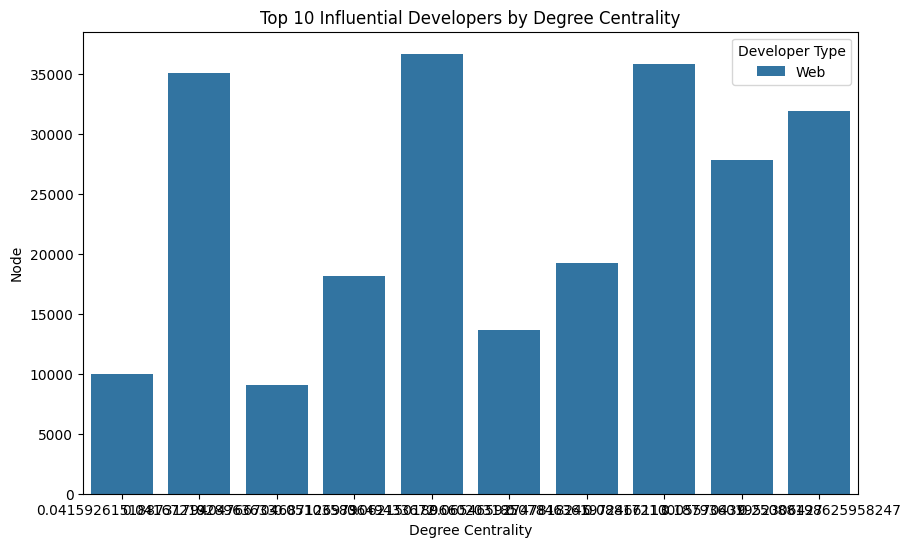

KeyboardInterrupt: 

In [16]:
# Question 1: Most influential developers (degree centrality)
degree_centrality = nx.degree_centrality(G)
top_10_influential = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
influential_df = pd.DataFrame(top_10_influential, columns=['Node', 'Degree Centrality'])
influential_df['Developer Type'] = [G.nodes[node]['developer_type'] for node in influential_df['Node']]
print("Top 10 Influential Developers:")
print(influential_df)

# Visualize top influential developers
plt.figure(figsize=(10, 6))
sns.barplot(x='Degree Centrality', y='Node', hue='Developer Type', data=influential_df)
plt.title('Top 10 Influential Developers by Degree Centrality')
plt.show()

# Question 2: Community detection (web vs. ML developers)
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(G))
community_sizes = [len(c) for c in communities]
print(f"Number of communities: {len(communities)}")
print(f"Community sizes: {community_sizes}")

# Analyze developer types in the largest community
largest_community = max(communities, key=len)
community_types = [G.nodes[node]['developer_type'] for node in largest_community]
type_counts = pd.Series(community_types).value_counts()
plt.figure(figsize=(8, 6))
type_counts.plot(kind='bar')
plt.title('Developer Types in Largest Community')
plt.xlabel('Developer Type')
plt.ylabel('Count')
plt.show()

# Question 3: Degree distribution by developer type
web_degrees = [d for n, d in G.degree() if G.nodes[n]['developer_type'] == 'Web']
ml_degrees = [d for n, d in G.degree() if G.nodes[n]['developer_type'] == 'ML']
plt.figure(figsize=(10, 6))
sns.histplot(web_degrees, color='blue', label='Web Developers', kde=True, stat='density')
sns.histplot(ml_degrees, color='orange', label='ML Developers', kde=True, stat='density')
plt.title('Degree Distribution by Developer Type')
plt.xlabel('Degree')
plt.ylabel('Density')
plt.legend()
plt.show()

# Question 4: Bridges between communities (betweenness centrality)
betweenness = nx.betweenness_centrality(G, k=1000)  # Use a sample for speed
top_10_bridges = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
bridges_df = pd.DataFrame(top_10_bridges, columns=['Node', 'Betweenness Centrality'])
bridges_df['Developer Type'] = [G.nodes[node]['developer_type'] for node in bridges_df['Node']]
print("Top 10 Bridges (Betweenness Centrality):")
print(bridges_df)

# Question 5: Clustering coefficient by developer type
clustering = nx.clustering(G)
web_clustering = [clustering[n] for n in G.nodes if G.nodes[n]['developer_type'] == 'Web']
ml_clustering = [clustering[n] for n in G.nodes if G.nodes[n]['developer_type'] == 'ML']
plt.figure(figsize=(10, 6))
sns.boxplot(data=[web_clustering, ml_clustering], palette=['blue', 'orange'])
plt.xticks([0, 1], ['Web Developers', 'ML Developers'])
plt.title('Clustering Coefficient by Developer Type')
plt.ylabel('Clustering Coefficient')
plt.show()

# Question 6: Predict developer type using network properties
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a feature DataFrame
features_df = pd.DataFrame({
    'Node': list(G.nodes),
    'Degree': [G.degree(n) for n in G.nodes],
    'Clustering': [clustering[n] for n in G.nodes],
    'Betweenness': [betweenness.get(n, 0) for n in G.nodes]
})
features_df['Developer Type'] = [G.nodes[n]['developer_type'] for n in G.nodes]
features_df['Target'] = features_df['Developer Type'].map({'Web': 0, 'ML': 1})

# Prepare data for classification
X = features_df[['Degree', 'Clustering', 'Betweenness']]
y = features_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of predicting developer type: {accuracy:.2f}")